In [1]:
%cd ..

/Users/crupley/gal/hoodie-development


In [47]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx

import shapely
import shapely.geometry as geometry
from descartes import PolygonPatch

from code.clusterize import *
from code.shapefiles import merge_shapefiles, make_shapefiles

In [4]:
fdf = load_featuredf()
print fdf.shape
fdf.head()

(7308, 11)


,lat,lon,taxable_value,grocery,restaurant,retail,ncrimes,sgnf,avg_hh_size,population,walkscore
0,37.750067,-122.441075,0.288994,-0.640949,-0.561362,-0.582297,-0.509058,0.477959,-0.017894,-0.102338,-0.025533
1,37.750196,-122.438933,0.336486,-0.576766,-0.465886,-0.515304,-0.509038,1.060608,0.253293,0.043369,0.146457
2,37.756794,-122.436270,0.350392,-0.131126,-0.396314,-0.227381,-0.313369,0.276664,0.244508,0.413731,0.701471
3,37.753529,-122.437050,0.327277,-0.298948,-0.286766,-0.356888,-0.456736,0.945703,0.372523,0.260021,0.594762
4,37.755758,-122.433400,0.355234,0.018376,-0.470065,-0.123353,-0.345027,0.674973,0.360681,0.530529,0.622791


In [5]:
cldf = pd.read_csv('results/CL07.csv')
print cldf.shape
cldf.head()

(23555, 4)


,source,target,num_edges,timestamp
0,4869,306,23555,1.447819e+09
1,793,1875,23554,1.447819e+09
2,2914,793,23553,1.447819e+09
3,1545,306,23552,1.447819e+09
4,4599,622,23551,1.447819e+09


In [7]:
g = nx.from_pandas_dataframe(cldf, source='source', target='target')

In [8]:
gcp = g.copy()
cldf['nneibs'] = cldf.apply(lambda x: cutcon(x, gcp), axis=1)


In [12]:
fn = 'data/uscensus/tl_2010_06075_tabblock10/tl_2010_06075_tabblock10.dbf'
mergedf = merge_shapefiles(fdf[['lat', 'lon']], fn)

In [13]:
gcp = g.copy()
cldf[cldf.nneibs <= 10].apply(lambda x: cutrow(x, gcp), axis=1)
cnum = assign_clusters(fdf.index, gcp)
polys = make_shapefiles(fdf[['lat', 'lon']], mergedf.polys, cnum)

In [16]:
polys

In [29]:
type(polys[0])

shapely.geometry.multipolygon.MultiPolygon

CPU times: user 52.3 s, sys: 283 ms, total: 52.6 s
Wall time: 53.6 s


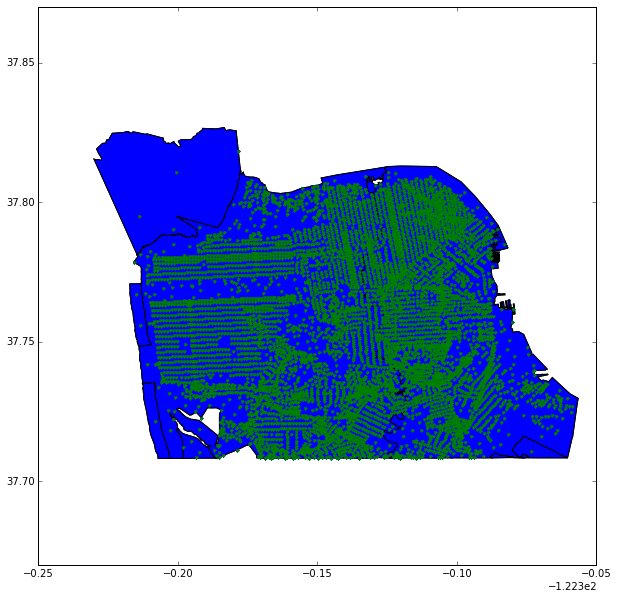

In [56]:
%%time
crange = range(5,7)

plots = []

for clust in crange:
    gcp = g.copy()
    cldf[cldf.nneibs <= clust].apply(lambda x: cutrow(x, gcp), axis=1)
    cnum = assign_clusters(fdf.index, gcp)
    polys = make_shapefiles(fdf[['lat', 'lon']], mergedf.polys, cnum)
    
#     plots.append(fdf.plot(kind='scatter', x='lon', y='lat', linewidths=0))
#     plots.append(plt.scatter(fdf.lon, fdf.lat, linewidths=0))
    plots.append(plt.plot(fdf.lon, fdf.lat, '.'))
    fig = plt.gcf()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    ax = plt.gca()
    for poly in polys:
        if type(poly) == shapely.geometry.multipolygon.MultiPolygon:
            for p in poly:
                patch = PolygonPatch(p)
                ax.add_patch(patch)
        else:
            patch = PolygonPatch(poly)
            ax.add_patch(patch)

    plt.axis('equal')

In [57]:
plots

[[<matplotlib.lines.Line2D at 0x10f2a2d90>],

In [58]:
fig = plt.figure()
im_ani = animation.ArtistAnimation(fig, plots, interval=50, repeat_delay=3000,
    blit=True)
plt.show()

In [61]:
im_ani.save('im.mp4')

ValueError: Cannot save animation: no writers are available. Please install mencoder or ffmpeg to save animations.

# vis`

In [102]:
def plot_polys(polylist, ax):
    for poly in polylist:
        if type(poly) == shapely.geometry.multipolygon.MultiPolygon:
            for p in poly:
                patch = PolygonPatch(p, zorder=1, fill=False)
                ax.add_patch(patch)
        else:
            patch = PolygonPatch(poly, zorder=1, fill=False)
            ax.add_patch(patch)

In [96]:
gcp = g.copy()
cldf[cldf.nneibs <= 28].apply(lambda x: cutrow(x, gcp), axis=1)
cnum = assign_clusters(fdf.index, gcp)
polys = make_shapefiles(fdf[['lat', 'lon']], mergedf.polys, cnum)

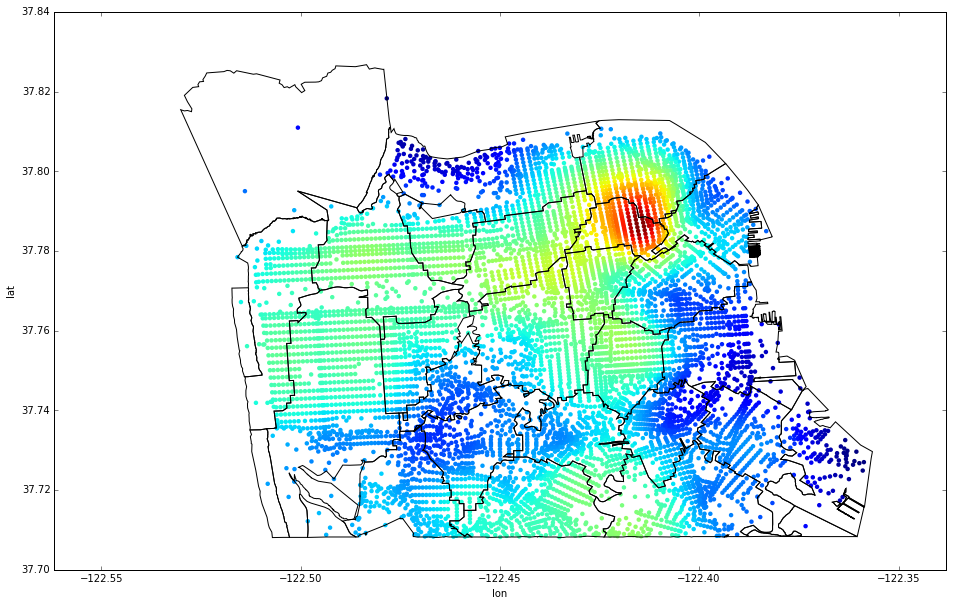

In [104]:
fdf.plot(kind='scatter', x='lon', y='lat', c='population', linewidths=0, figsize=(16,16),
        cmap='jet', colorbar=False)
ax = plt.gca()
plot_polys(polys, ax)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.margins(0)
plt.axis('equal')

fig = plt.gcf()
fig.set_size_inches(16,10)
plt.savefig('images/datneib_population.png');